In [ ]:
# mlflow server -h 0.0.0.0 --default-artifact-root s3://mlflow-bucket-114


In [2]:
tracking_uri = "http://ec2-16-170-247-92.eu-north-1.compute.amazonaws.com:5000"

In [3]:
import mlflow

mlflow.set_tracking_uri(tracking_uri)

with mlflow.start_run():
    mlflow.log_param("param1",15)
    mlflow.log_metric("metric1",0.89)

🏃 View run fun-calf-380 at: http://ec2-16-170-247-92.eu-north-1.compute.amazonaws.com:5000/#/experiments/0/runs/d3b2f65bd3bb47d7b2aefe922b90f3d1
🧪 View experiment at: http://ec2-16-170-247-92.eu-north-1.compute.amazonaws.com:5000/#/experiments/0


In [4]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split,cross_val_predict,StratifiedKFold
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df  = pd.read_csv("data/preprocessing_df.csv")
df

,Unnamed: 0,text,category,word_count,num_chars,num_punctuation_chars
0,0,family mormon never tried explain still stare ...,1,39,259,0
1,1,buddhism much lot compatible christianity espe...,1,196,1268,0
2,2,seriously say thing first get complex explain ...,-1,86,459,0
3,3,learned want teach different focus goal wrappi...,0,29,167,0
4,4,benefit may want read living buddha living chr...,1,112,690,0
...,...,...,...,...,...,...
199697,162975,crore paid neerav modi recovered congress lead...,-1,18,107,0
199698,162976,dear rss terrorist payal gawar modi killing pl...,-1,36,248,0
199699,162977,cover interaction forum left,0,9,50,0
199700,162978,big project came india modi dream project happ...,0,13,77,0


In [6]:
df.text = df.text.fillna("")


In [7]:
vectorizer = CountVectorizer(max_features=10000)

In [8]:
X = vectorizer.fit_transform(df.text)
y = df.category

In [9]:
X

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 2521737 stored elements and shape (199702, 10000)>

In [10]:
y

0         1
1         1
2        -1
3         0
4         1
         ..
199697   -1
199698   -1
199699    0
199700    0
199701    1
Name: category, Length: 199702, dtype: int64

In [11]:
mlflow.set_tracking_uri(tracking_uri)

In [12]:
mlflow.set_experiment("RF baseline")

<Experiment: artifact_location='s3://mlflow-bucket-114/615257078353441445', creation_time=1751070094398, experiment_id='615257078353441445', last_update_time=1751070094398, lifecycle_stage='active', name='RF baseline', tags={}>

2025/06/28 03:52:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/28 03:52:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RF_Baseline_Split at: http://ec2-16-170-247-92.eu-north-1.compute.amazonaws.com:5000/#/experiments/615257078353441445/runs/56ae130763304c1fbd6bdaec4ba9a788
🧪 View experiment at: http://ec2-16-170-247-92.eu-north-1.compute.amazonaws.com:5000/#/experiments/615257078353441445
Accuracy : 0.742294884955309


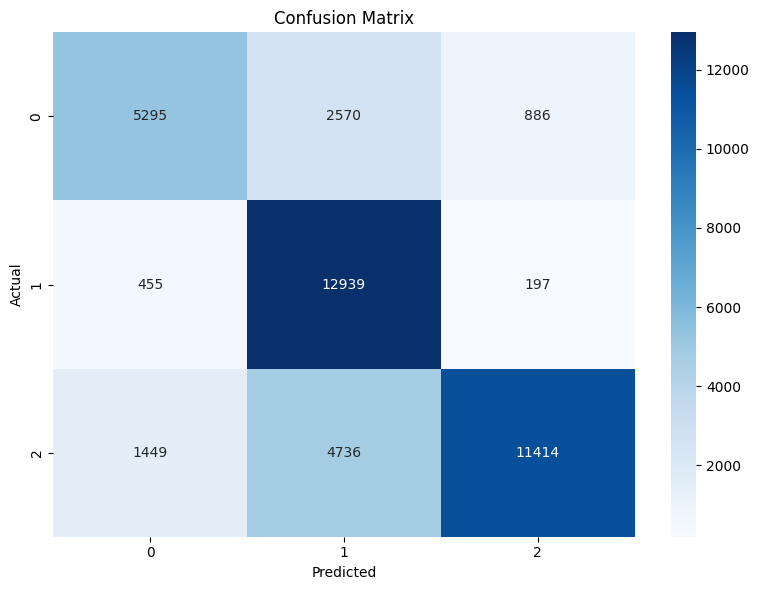

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=114, stratify=y)

# 4. MLflow deneyi
with mlflow.start_run() as run:
    mlflow.set_tag("mlflow.runName", "RF_Baseline_Split")
    mlflow.set_tag("experiment_type", "baseline")
    mlflow.set_tag("model_type", "RFClassifier")
    mlflow.set_tag("description", "Baseline RF model for sentiment analysis using bag of words")

    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("vectorizer_max_features", vectorizer.max_features)

    n_estimators = 200
    max_depth = 15
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)

    # Model eğitimi
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,class_weight="balanced", random_state=114)
    model.fit(X_train, y_train)

    # Tahmin ve metrikler
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

    classification_rep = classification_report(y_test, y_pred, output_dict=True)
    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Model ve veri loglama
    mlflow.sklearn.log_model(model, "random_forest_model")
    df.to_csv("dataset.csv", index=False)
    mlflow.log_artifact("dataset.csv")

print(f"Accuracy : {accuracy}")

In [14]:
print(classification_rep)

{'-1': {'precision': 1.0, 'recall': 0.0043423608730430805, 'f1-score': 0.008647172602116282, 'support': 8751.0}, '0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 13591.0}, '1': {'precision': 0.44104453299250684, 'recall': 1.0, 'f1-score': 0.6121178393794998, 'support': 17599.0}, 'accuracy': 0.44157632507949224, 'macro avg': {'precision': 0.48034817766416893, 'recall': 0.33478078695768104, 'f1-score': 0.2069216706605387, 'support': 39941.0}, 'weighted avg': {'precision': 0.41343338264277624, 'recall': 0.44157632507949224, 'f1-score': 0.271608954775317, 'support': 39941.0}}
